# WeatherPy
***

## Analysis

### Methodology
- 1,779 samples gathered by picking 20 random longitudinal coordinates from each latitude (90S to 90N)
- Used citipy library to find nearest city / country code for each latitude / longitude combination, keeping only unique cities
- Fed city / country code combination to OpenWeather API -- returned weather data for 1,590 cities (~89%).

### Observations
- The sample generally falls between 60S and 80N degrees latitude, probably because of the lack of human habitation at the poles (the north pole is entirely ocean, Antarctica has no cities), as well as the 'closest city' algorithm of citipy, the library used to find the sample cities by lat / long.
- Temperature displays a distinct boomerang pattern. The southern hemisphere is entering autumn, so temperatures trend higher overall than the northern hemisphere, which is now entering spring. However, there is a clear trend on both sides toward higher temperatures as the latitudes near the equator. There is a cluster of cities with max temps higher than the equator from about 15N to 20N; however, the cluster seems to be located within the Tropic of Cancer, which is generally considered equatorial.
- There seems to be a strong band of high humidity (between 80% and 100%) across the entire sample. However, there seems to be a higher relative proportion of cities immediately around the equator (between the Tropics of Cancer and Capricorn) with higher humidity. Interestingly, there seem to be two clusters of cities which have very low humidities around 25N and 25S -- perhaps because of the location of the Sahara (23N) and the Kalahari (23S) deserts? 
- Cloud cover does not seem to be correlated with latitude at all, but there does seem to be a cluster of lower wind speeds right over the equator.

In [1]:
import openweathermapy
from citipy import citipy
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np
import requests
from config import api_key
from collections import defaultdict
import json
from matplotlib import style
style.use('fivethirtyeight')
import time
import datetime

In [3]:
# set min/max coords for randomized search of cities
max_latitude = 90
min_latitude = -90
max_longitude = 180
min_longitude = -180

cities = []

#for latitude in range(min_latitude, max_latitude, 1):
for latitude in np.linspace(min_latitude, max_latitude, num=360, endpoint=True):
    for _ in range(1, 21):
        lng = random.uniform(min_longitude, max_longitude)
        lat = random.uniform(latitude, latitude + 1)
        city = citipy.nearest_city(lat, lng)
        city_data = f'{city.city_name},{city.country_code}'
        if city_data not in cities:
            cities.append(city_data)
            
#the free api only allows 60 calls per minute, so divide into 34 samples. This should get ~55 cities per split.
samples = np.array_split(cities, 34)

print("City Location Complete")

City Location Complete


In [4]:
# Save config information.
url = "http://api.openweathermap.org/data/2.5/weather?"
units = "imperial"

# Build partial query URL
query_url = f"{url}appid={api_key}&units={units}&q="

# set up dictionary to hold data
city_data_dict = defaultdict(list)

divider = f'*********************************'
print(divider)
print('* BEGINNING DATA RETRIEVAL..... *')
print(divider)

for index, target_cities in enumerate(samples):
    for idx, target_city in enumerate(target_cities):
        print(f'Processing Record {idx} of Set {index} | {target_city}')
        response = requests.get(query_url + target_city)
        response_data = response.json()

        #this is not a particularly pythonic way to build an exception, but in this program, we want all the data
        #or none of it. So if we get a 200 but there is a problem with one of the fields in the API, we do not want
        #it getting in the table. Dump the json() and troubleshoot. If we get anything but a 200, let us know about it.
        #It is mostly likely a 404 message, telling us it can't find the city. We will not load any data for a city we
        #can't find.
        if response.status_code == 200:
            print(f'Data found (status code: {response.status_code}) | {target_city}')
            try:
                city_data_dict['city_name'].append(response_data['name'])
                city_data_dict['city_country_code'].append(response_data['sys']['country'])
                city_data_dict['city_id'].append(response_data['id'])
                city_data_dict['city_lat'].append(response_data['coord']['lat'])
                city_data_dict['city_lng'].append(response_data['coord']['lon'])
                city_data_dict['city_max_temp'].append(response_data['main']['temp_max'])
                city_data_dict['city_humidity'].append(response_data['main']['humidity'])
                city_data_dict['city_wind_speed'].append(response_data['wind']['speed'])
                city_data_dict['city_cloud_cover'].append(response_data['clouds']['all'])
                city_data_dict['record_dt'].append(response_data['dt'])
                print(f'Data loaded successfully | {target_city}')
                print(divider)
            except KeyError:
                print(f'We got a good response (status code: {response.status_code}), but did not receive good info. \
                | {target_city }')
                print(f'API Response: ')
                print(json.dumps(response_data))
        else:
            try:
                print(f"ERROR: Data retrieval unsuccessful for {target_city}. Code: {response_data['cod']} \
                      MSG: {response_data['message']}")
            except KeyError:
                print(f'SEVERE ERROR: Data retrieval unsuccessful for {target_city}. Code: {response.status_code}')
    print("Sleeping 60 seconds before next round to avoid usage limits")
    time.sleep(60)
    
print(divider)
print("* DATA COLLECTION COMPLETE..... ")        
              


    

*********************************
* BEGINNING DATA RETRIEVAL..... *
*********************************
Processing Record 0 of Set 0 | taolanaro,mg
ERROR: Data retrieval unsuccessful for taolanaro,mg. Code: 404                       MSG: city not found
Processing Record 1 of Set 0 | hobart,au
Data found (status code: 200) | hobart,au
Data loaded successfully | hobart,au
*********************************
Processing Record 2 of Set 0 | port alfred,za
Data found (status code: 200) | port alfred,za
Data loaded successfully | port alfred,za
*********************************
Processing Record 3 of Set 0 | rikitea,pf
Data found (status code: 200) | rikitea,pf
Data loaded successfully | rikitea,pf
*********************************
Processing Record 4 of Set 0 | hermanus,za
Data found (status code: 200) | hermanus,za
Data loaded successfully | hermanus,za
*********************************
Processing Record 5 of Set 0 | ushuaia,ar
Data found (status code: 200) | ushuaia,ar
Data loaded successfully

Data found (status code: 200) | burnie,au
Data loaded successfully | burnie,au
*********************************
Processing Record 51 of Set 0 | saldanha,za
Data found (status code: 200) | saldanha,za
Data loaded successfully | saldanha,za
*********************************
Processing Record 52 of Set 0 | wanaka,nz
Data found (status code: 200) | wanaka,nz
Data loaded successfully | wanaka,nz
*********************************
Sleeping 60 seconds before next round to avoid usage limits
Processing Record 0 of Set 1 | rio grande,br
Data found (status code: 200) | rio grande,br
Data loaded successfully | rio grande,br
*********************************
Processing Record 1 of Set 1 | otane,nz
Data found (status code: 200) | otane,nz
Data loaded successfully | otane,nz
*********************************
Processing Record 2 of Set 1 | hokitika,nz
Data found (status code: 200) | hokitika,nz
Data loaded successfully | hokitika,nz
*********************************
Processing Record 3 of Set 1 | mar

Data found (status code: 200) | beloha,mg
Data loaded successfully | beloha,mg
*********************************
Processing Record 48 of Set 1 | adelaide,au
Data found (status code: 200) | adelaide,au
Data loaded successfully | adelaide,au
*********************************
Processing Record 49 of Set 1 | port macquarie,au
Data found (status code: 200) | port macquarie,au
Data loaded successfully | port macquarie,au
*********************************
Processing Record 50 of Set 1 | scottsburgh,za
ERROR: Data retrieval unsuccessful for scottsburgh,za. Code: 404                       MSG: city not found
Processing Record 51 of Set 1 | sao joao da barra,br
Data found (status code: 200) | sao joao da barra,br
Data loaded successfully | sao joao da barra,br
*********************************
Processing Record 52 of Set 1 | cootamundra,au
Data found (status code: 200) | cootamundra,au
Data loaded successfully | cootamundra,au
*********************************
Sleeping 60 seconds before next rou

Data found (status code: 200) | puerto ayora,ec
Data loaded successfully | puerto ayora,ec
*********************************
Processing Record 46 of Set 2 | marcona,pe
ERROR: Data retrieval unsuccessful for marcona,pe. Code: 404                       MSG: city not found
Processing Record 47 of Set 2 | dalby,au
Data found (status code: 200) | dalby,au
Data loaded successfully | dalby,au
*********************************
Processing Record 48 of Set 2 | mount isa,au
Data found (status code: 200) | mount isa,au
Data loaded successfully | mount isa,au
*********************************
Processing Record 49 of Set 2 | port hedland,au
Data found (status code: 200) | port hedland,au
Data loaded successfully | port hedland,au
*********************************
Processing Record 50 of Set 2 | koster,za
Data found (status code: 200) | koster,za
Data loaded successfully | koster,za
*********************************
Processing Record 51 of Set 2 | boksburg,za
Data found (status code: 200) | boksburg,

Data found (status code: 200) | calama,cl
Data loaded successfully | calama,cl
*********************************
Processing Record 43 of Set 3 | yeppoon,au
Data found (status code: 200) | yeppoon,au
Data loaded successfully | yeppoon,au
*********************************
Processing Record 44 of Set 3 | georgetown,sh
Data found (status code: 200) | georgetown,sh
Data loaded successfully | georgetown,sh
*********************************
Processing Record 45 of Set 3 | nosy varika,mg
Data found (status code: 200) | nosy varika,mg
Data loaded successfully | nosy varika,mg
*********************************
Processing Record 46 of Set 3 | ghanzi,bw
Data found (status code: 200) | ghanzi,bw
Data loaded successfully | ghanzi,bw
*********************************
Processing Record 47 of Set 3 | tadine,nc
Data found (status code: 200) | tadine,nc
Data loaded successfully | tadine,nc
*********************************
Processing Record 48 of Set 3 | beira,mz
Data found (status code: 200) | beira,mz


Data found (status code: 200) | viloco,bo
Data loaded successfully | viloco,bo
*********************************
Processing Record 42 of Set 4 | vavatenina,mg
Data found (status code: 200) | vavatenina,mg
Data loaded successfully | vavatenina,mg
*********************************
Processing Record 43 of Set 4 | angoche,mz
Data found (status code: 200) | angoche,mz
Data loaded successfully | angoche,mz
*********************************
Processing Record 44 of Set 4 | grand gaube,mu
Data found (status code: 200) | grand gaube,mu
Data loaded successfully | grand gaube,mu
*********************************
Processing Record 45 of Set 4 | neiafu,to
Data found (status code: 200) | neiafu,to
Data loaded successfully | neiafu,to
*********************************
Processing Record 46 of Set 4 | huarmey,pe
Data found (status code: 200) | huarmey,pe
Data loaded successfully | huarmey,pe
*********************************
Processing Record 47 of Set 4 | atuona,pf
Data found (status code: 200) | atuon

Data found (status code: 200) | parana,br
Data loaded successfully | parana,br
*********************************
Processing Record 41 of Set 5 | benguela,ao
Data found (status code: 200) | benguela,ao
Data loaded successfully | benguela,ao
*********************************
Processing Record 42 of Set 5 | chicama,pe
Data found (status code: 200) | chicama,pe
Data loaded successfully | chicama,pe
*********************************
Processing Record 43 of Set 5 | salvador,br
Data found (status code: 200) | salvador,br
Data loaded successfully | salvador,br
*********************************
Processing Record 44 of Set 5 | sao jose da coroa grande,br
Data found (status code: 200) | sao jose da coroa grande,br
Data loaded successfully | sao jose da coroa grande,br
*********************************
Processing Record 45 of Set 5 | honiara,sb
Data found (status code: 200) | honiara,sb
Data loaded successfully | honiara,sb
*********************************
Processing Record 46 of Set 5 | port mor

Data found (status code: 200) | malanje,ao
Data loaded successfully | malanje,ao
*********************************
Processing Record 40 of Set 6 | ipinda,tz
Data found (status code: 200) | ipinda,tz
Data loaded successfully | ipinda,tz
*********************************
Processing Record 41 of Set 6 | conceicao do araguaia,br
Data found (status code: 200) | conceicao do araguaia,br
Data loaded successfully | conceicao do araguaia,br
*********************************
Processing Record 42 of Set 6 | atambua,id
Data found (status code: 200) | atambua,id
Data loaded successfully | atambua,id
*********************************
Processing Record 43 of Set 6 | matai,tz
Data found (status code: 200) | matai,tz
Data loaded successfully | matai,tz
*********************************
Processing Record 44 of Set 6 | gizo,sb
Data found (status code: 200) | gizo,sb
Data loaded successfully | gizo,sb
*********************************
Processing Record 45 of Set 6 | lolua,tv
ERROR: Data retrieval unsucces

Data found (status code: 200) | ambon,id
Data loaded successfully | ambon,id
*********************************
Processing Record 39 of Set 7 | padang,id
Data found (status code: 200) | padang,id
Data loaded successfully | padang,id
*********************************
Processing Record 40 of Set 7 | itupiranga,br
Data found (status code: 200) | itupiranga,br
Data loaded successfully | itupiranga,br
*********************************
Processing Record 41 of Set 7 | metro,id
Data found (status code: 200) | metro,id
Data loaded successfully | metro,id
*********************************
Processing Record 42 of Set 7 | martapura,id
Data found (status code: 200) | martapura,id
Data loaded successfully | martapura,id
*********************************
Processing Record 43 of Set 7 | jutai,br
Data found (status code: 200) | jutai,br
Data loaded successfully | jutai,br
*********************************
Processing Record 44 of Set 7 | madang,pg
Data found (status code: 200) | madang,pg
Data loaded suc

ERROR: Data retrieval unsuccessful for kismayo,so. Code: 404                       MSG: city not found
Processing Record 39 of Set 8 | biak,id
Data found (status code: 200) | biak,id
Data loaded successfully | biak,id
*********************************
Processing Record 40 of Set 8 | coahuayana,mx
Data found (status code: 200) | coahuayana,mx
Data loaded successfully | coahuayana,mx
*********************************
Processing Record 41 of Set 8 | lorengau,pg
Data found (status code: 200) | lorengau,pg
Data loaded successfully | lorengau,pg
*********************************
Processing Record 42 of Set 8 | luis correia,br
Data found (status code: 200) | luis correia,br
Data loaded successfully | luis correia,br
*********************************
Processing Record 43 of Set 8 | itarema,br
Data found (status code: 200) | itarema,br
Data loaded successfully | itarema,br
*********************************
Processing Record 44 of Set 8 | fonte boa,br
Data found (status code: 200) | fonte boa,br

Data found (status code: 200) | luba,gq
Data loaded successfully | luba,gq
*********************************
Processing Record 37 of Set 9 | rawannawi,ki
ERROR: Data retrieval unsuccessful for rawannawi,ki. Code: 404                       MSG: city not found
Processing Record 38 of Set 9 | carutapera,br
Data found (status code: 200) | carutapera,br
Data loaded successfully | carutapera,br
*********************************
Processing Record 39 of Set 9 | wamba,cd
Data found (status code: 200) | wamba,cd
Data loaded successfully | wamba,cd
*********************************
Processing Record 40 of Set 9 | ebebiyin,gq
Data found (status code: 200) | ebebiyin,gq
Data loaded successfully | ebebiyin,gq
*********************************
Processing Record 41 of Set 9 | ternate,id
Data found (status code: 200) | ternate,id
Data loaded successfully | ternate,id
*********************************
Processing Record 42 of Set 9 | banda aceh,id
Data found (status code: 200) | banda aceh,id
Data loaded

Data found (status code: 200) | ugoofaaru,mv
Data loaded successfully | ugoofaaru,mv
*********************************
Processing Record 35 of Set 10 | puerto escondido,mx
Data found (status code: 200) | puerto escondido,mx
Data loaded successfully | puerto escondido,mx
*********************************
Processing Record 36 of Set 10 | kloulklubed,pw
Data found (status code: 200) | kloulklubed,pw
Data loaded successfully | kloulklubed,pw
*********************************
Processing Record 37 of Set 10 | bonthe,sl
Data found (status code: 200) | bonthe,sl
Data loaded successfully | bonthe,sl
*********************************
Processing Record 38 of Set 10 | marang,my
Data found (status code: 200) | marang,my
Data loaded successfully | marang,my
*********************************
Processing Record 39 of Set 10 | galle,lk
Data found (status code: 200) | galle,lk
Data loaded successfully | galle,lk
*********************************
Processing Record 40 of Set 10 | ciudad bolivar,ve
Data fou

Data found (status code: 200) | bedele,et
Data loaded successfully | bedele,et
*********************************
Processing Record 34 of Set 11 | gambela,et
Data found (status code: 200) | gambela,et
Data loaded successfully | gambela,et
*********************************
Processing Record 35 of Set 11 | jalingo,ng
Data found (status code: 200) | jalingo,ng
Data loaded successfully | jalingo,ng
*********************************
Processing Record 36 of Set 11 | asosa,et
Data found (status code: 200) | asosa,et
Data loaded successfully | asosa,et
*********************************
Processing Record 37 of Set 11 | nicoya,cr
Data found (status code: 200) | nicoya,cr
Data loaded successfully | nicoya,cr
*********************************
Processing Record 38 of Set 11 | siocon,ph
Data found (status code: 200) | siocon,ph
Data loaded successfully | siocon,ph
*********************************
Processing Record 39 of Set 11 | hatillo de loba,co
Data found (status code: 200) | hatillo de loba,co
D

Data found (status code: 200) | san andres,co
Data loaded successfully | san andres,co
*********************************
Processing Record 34 of Set 12 | maiduguri,ng
Data found (status code: 200) | maiduguri,ng
Data loaded successfully | maiduguri,ng
*********************************
Processing Record 35 of Set 12 | oistins,bb
Data found (status code: 200) | oistins,bb
Data loaded successfully | oistins,bb
*********************************
Processing Record 36 of Set 12 | ouargaye,bf
Data found (status code: 200) | ouargaye,bf
Data loaded successfully | ouargaye,bf
*********************************
Processing Record 37 of Set 12 | diapaga,bf
Data found (status code: 200) | diapaga,bf
Data loaded successfully | diapaga,bf
*********************************
Processing Record 38 of Set 12 | tinogboc,ph
Data found (status code: 200) | tinogboc,ph
Data loaded successfully | tinogboc,ph
*********************************
Processing Record 39 of Set 12 | kampong cham,kh
Data found (status code

Data found (status code: 200) | sainte-marie,mq
Data loaded successfully | sainte-marie,mq
*********************************
Processing Record 35 of Set 13 | sur,om
Data found (status code: 200) | sur,om
Data loaded successfully | sur,om
*********************************
Processing Record 36 of Set 13 | addi ugri,er
ERROR: Data retrieval unsuccessful for addi ugri,er. Code: 404                       MSG: city not found
Processing Record 37 of Set 13 | tanout,ne
Data found (status code: 200) | tanout,ne
Data loaded successfully | tanout,ne
*********************************
Processing Record 38 of Set 13 | iralaya,hn
Data found (status code: 200) | iralaya,hn
Data loaded successfully | iralaya,hn
*********************************
Processing Record 39 of Set 13 | aloleng,ph
Data found (status code: 200) | aloleng,ph
Data loaded successfully | aloleng,ph
*********************************
Processing Record 40 of Set 13 | pinotepa nacional,mx
ERROR: Data retrieval unsuccessful for pinotepa n

Data found (status code: 200) | zhuhai,cn
Data loaded successfully | zhuhai,cn
*********************************
Processing Record 35 of Set 14 | goundam,ml
Data found (status code: 200) | goundam,ml
Data loaded successfully | goundam,ml
*********************************
Processing Record 36 of Set 14 | george town,ky
Data found (status code: 200) | george town,ky
Data loaded successfully | george town,ky
*********************************
Processing Record 37 of Set 14 | faya,td
ERROR: Data retrieval unsuccessful for faya,td. Code: 404                       MSG: city not found
Processing Record 38 of Set 14 | san ignacio,bz
Data found (status code: 200) | san ignacio,bz
Data loaded successfully | san ignacio,bz
*********************************
Processing Record 39 of Set 14 | porbandar,in
Data found (status code: 200) | porbandar,in
Data loaded successfully | porbandar,in
*********************************
Processing Record 40 of Set 14 | nishihara,jp
Data found (status code: 200) | ni

ERROR: Data retrieval unsuccessful for udala,in. Code: 404                       MSG: city not found
Processing Record 35 of Set 15 | isla mujeres,mx
Data found (status code: 200) | isla mujeres,mx
Data loaded successfully | isla mujeres,mx
*********************************
Processing Record 36 of Set 15 | mecca,sa
Data found (status code: 200) | mecca,sa
Data loaded successfully | mecca,sa
*********************************
Processing Record 37 of Set 15 | calnali,mx
Data found (status code: 200) | calnali,mx
Data loaded successfully | calnali,mx
*********************************
Processing Record 38 of Set 15 | abu dhabi,ae
Data found (status code: 200) | abu dhabi,ae
Data loaded successfully | abu dhabi,ae
*********************************
Processing Record 39 of Set 15 | mohpa,in
Data found (status code: 200) | mohpa,in
Data loaded successfully | mohpa,in
*********************************
Processing Record 40 of Set 15 | tessalit,ml
Data found (status code: 200) | tessalit,ml
Data l

Data found (status code: 200) | jiwani,pk
Data loaded successfully | jiwani,pk
*********************************
Processing Record 34 of Set 16 | govindgarh,in
Data found (status code: 200) | govindgarh,in
Data loaded successfully | govindgarh,in
*********************************
Processing Record 35 of Set 16 | suao,tw
ERROR: Data retrieval unsuccessful for suao,tw. Code: 404                       MSG: city not found
Processing Record 36 of Set 16 | chaozhou,cn
Data found (status code: 200) | chaozhou,cn
Data loaded successfully | chaozhou,cn
*********************************
Processing Record 37 of Set 16 | matamoros,mx
Data found (status code: 200) | matamoros,mx
Data loaded successfully | matamoros,mx
*********************************
Processing Record 38 of Set 16 | lotung,tw
ERROR: Data retrieval unsuccessful for lotung,tw. Code: 404                       MSG: city not found
Processing Record 39 of Set 16 | jhudo,pk
Data found (status code: 200) | jhudo,pk
Data loaded successfull

Data found (status code: 200) | valentin gomez farias,mx
Data loaded successfully | valentin gomez farias,mx
*********************************
Processing Record 34 of Set 17 | springfield,us
Data found (status code: 200) | springfield,us
Data loaded successfully | springfield,us
*********************************
Processing Record 35 of Set 17 | hongjiang,cn
Data found (status code: 200) | hongjiang,cn
Data loaded successfully | hongjiang,cn
*********************************
Processing Record 36 of Set 17 | lachhmangarh,in
Data found (status code: 200) | lachhmangarh,in
Data loaded successfully | lachhmangarh,in
*********************************
Processing Record 37 of Set 17 | sakakah,sa
ERROR: Data retrieval unsuccessful for sakakah,sa. Code: 404                       MSG: city not found
Processing Record 38 of Set 17 | safwah,sa
ERROR: Data retrieval unsuccessful for safwah,sa. Code: 404                       MSG: city not found
Processing Record 39 of Set 17 | iglas,in
Data found (s

Data found (status code: 200) | along,in
Data loaded successfully | along,in
*********************************
Processing Record 34 of Set 18 | tacoronte,es
Data found (status code: 200) | tacoronte,es
Data loaded successfully | tacoronte,es
*********************************
Processing Record 35 of Set 18 | oyama,jp
Data found (status code: 200) | oyama,jp
Data loaded successfully | oyama,jp
*********************************
Processing Record 36 of Set 18 | bardsir,ir
Data found (status code: 200) | bardsir,ir
Data loaded successfully | bardsir,ir
*********************************
Processing Record 37 of Set 18 | fukue,jp
Data found (status code: 200) | fukue,jp
Data loaded successfully | fukue,jp
*********************************
Processing Record 38 of Set 18 | shadegan,ir
Data found (status code: 200) | shadegan,ir
Data loaded successfully | shadegan,ir
*********************************
Processing Record 39 of Set 18 | college station,us
Data found (status code: 200) | college stati

Data found (status code: 200) | beppu,jp
Data loaded successfully | beppu,jp
*********************************
Processing Record 33 of Set 19 | columbus,us
Data found (status code: 200) | columbus,us
Data loaded successfully | columbus,us
*********************************
Processing Record 34 of Set 19 | artesia,us
Data found (status code: 200) | artesia,us
Data loaded successfully | artesia,us
*********************************
Processing Record 35 of Set 19 | georgetown,us
Data found (status code: 200) | georgetown,us
Data loaded successfully | georgetown,us
*********************************
Processing Record 36 of Set 19 | centerville,us
Data found (status code: 200) | centerville,us
Data loaded successfully | centerville,us
*********************************
Processing Record 37 of Set 19 | xining,cn
Data found (status code: 200) | xining,cn
Data loaded successfully | xining,cn
*********************************
Processing Record 38 of Set 19 | orangeburg,us
Data found (status code: 2

Data found (status code: 200) | fayetteville,us
Data loaded successfully | fayetteville,us
*********************************
Processing Record 33 of Set 20 | tazmalt,dz
Data found (status code: 200) | tazmalt,dz
Data loaded successfully | tazmalt,dz
*********************************
Processing Record 34 of Set 20 | ukiah,us
Data found (status code: 200) | ukiah,us
Data loaded successfully | ukiah,us
*********************************
Processing Record 35 of Set 20 | hunza,pk
ERROR: Data retrieval unsuccessful for hunza,pk. Code: 404                       MSG: city not found
Processing Record 36 of Set 20 | manzil salim,tn
Data found (status code: 200) | manzil salim,tn
Data loaded successfully | manzil salim,tn
*********************************
Processing Record 37 of Set 20 | mooresville,us
Data found (status code: 200) | mooresville,us
Data loaded successfully | mooresville,us
*********************************
Processing Record 38 of Set 20 | asmar,af
Data found (status code: 200) | a

Data found (status code: 200) | mastic beach,us
Data loaded successfully | mastic beach,us
*********************************
Processing Record 33 of Set 21 | wajima,jp
Data found (status code: 200) | wajima,jp
Data loaded successfully | wajima,jp
*********************************
Processing Record 34 of Set 21 | lamar,us
Data found (status code: 200) | lamar,us
Data loaded successfully | lamar,us
*********************************
Processing Record 35 of Set 21 | ahar,ir
Data found (status code: 200) | ahar,ir
Data loaded successfully | ahar,ir
*********************************
Processing Record 36 of Set 21 | topeka,us
Data found (status code: 200) | topeka,us
Data loaded successfully | topeka,us
*********************************
Processing Record 37 of Set 21 | silvan,tr
Data found (status code: 200) | silvan,tr
Data loaded successfully | silvan,tr
*********************************
Processing Record 38 of Set 21 | benidorm,es
Data found (status code: 200) | benidorm,es
Data loaded suc

Data found (status code: 200) | xingcheng,cn
Data loaded successfully | xingcheng,cn
*********************************
Processing Record 32 of Set 22 | louisbourg,ca
ERROR: Data retrieval unsuccessful for louisbourg,ca. Code: 404                       MSG: city not found
Processing Record 33 of Set 22 | nardaran,az
Data found (status code: 200) | nardaran,az
Data loaded successfully | nardaran,az
*********************************
Processing Record 34 of Set 22 | winnemucca,us
Data found (status code: 200) | winnemucca,us
Data loaded successfully | winnemucca,us
*********************************
Processing Record 35 of Set 22 | almazar,uz
Data found (status code: 200) | almazar,uz
Data loaded successfully | almazar,uz
*********************************
Processing Record 36 of Set 22 | hami,cn
Data found (status code: 200) | hami,cn
Data loaded successfully | hami,cn
*********************************
Processing Record 37 of Set 22 | streator,us
Data found (status code: 200) | streator,us


Data found (status code: 200) | waverly,us
Data loaded successfully | waverly,us
*********************************
Processing Record 31 of Set 23 | mountain home,us
Data found (status code: 200) | mountain home,us
Data loaded successfully | mountain home,us
*********************************
Processing Record 32 of Set 23 | meihekou,cn
Data found (status code: 200) | meihekou,cn
Data loaded successfully | meihekou,cn
*********************************
Processing Record 33 of Set 23 | north bend,us
Data found (status code: 200) | north bend,us
Data loaded successfully | north bend,us
*********************************
Processing Record 34 of Set 23 | utica,us
Data found (status code: 200) | utica,us
Data loaded successfully | utica,us
*********************************
Processing Record 35 of Set 23 | monsummano terme,it
Data found (status code: 200) | monsummano terme,it
Data loaded successfully | monsummano terme,it
*********************************
Processing Record 36 of Set 23 | belogr

Data found (status code: 200) | willmar,us
Data loaded successfully | willmar,us
*********************************
Processing Record 31 of Set 24 | la grande,us
Data found (status code: 200) | la grande,us
Data loaded successfully | la grande,us
*********************************
Processing Record 32 of Set 24 | iki-burul,ru
Data found (status code: 200) | iki-burul,ru
Data loaded successfully | iki-burul,ru
*********************************
Processing Record 33 of Set 24 | ucluelet,ca
Data found (status code: 200) | ucluelet,ca
Data loaded successfully | ucluelet,ca
*********************************
Processing Record 34 of Set 24 | balkhash,kz
Data found (status code: 200) | balkhash,kz
Data loaded successfully | balkhash,kz
*********************************
Processing Record 35 of Set 24 | baruun-urt,mn
Data found (status code: 200) | baruun-urt,mn
Data loaded successfully | baruun-urt,mn
*********************************
Processing Record 36 of Set 24 | miles city,us
Data found (stat

Data found (status code: 200) | hare bay,ca
Data loaded successfully | hare bay,ca
*********************************
Processing Record 30 of Set 25 | aichach,de
Data found (status code: 200) | aichach,de
Data loaded successfully | aichach,de
*********************************
Processing Record 31 of Set 25 | shubarshi,kz
Data found (status code: 200) | shubarshi,kz
Data loaded successfully | shubarshi,kz
*********************************
Processing Record 32 of Set 25 | englehart,ca
Data found (status code: 200) | englehart,ca
Data loaded successfully | englehart,ca
*********************************
Processing Record 33 of Set 25 | amurzet,ru
Data found (status code: 200) | amurzet,ru
Data loaded successfully | amurzet,ru
*********************************
Processing Record 34 of Set 25 | atasu,kz
Data found (status code: 200) | atasu,kz
Data loaded successfully | atasu,kz
*********************************
Processing Record 35 of Set 25 | skibbereen,ie
Data found (status code: 200) | ski

Data found (status code: 200) | dombarovskiy,ru
Data loaded successfully | dombarovskiy,ru
*********************************
Processing Record 27 of Set 26 | kholtoson,ru
Data found (status code: 200) | kholtoson,ru
Data loaded successfully | kholtoson,ru
*********************************
Processing Record 28 of Set 26 | matagami,ca
Data found (status code: 200) | matagami,ca
Data loaded successfully | matagami,ca
*********************************
Processing Record 29 of Set 26 | sioux lookout,ca
Data found (status code: 200) | sioux lookout,ca
Data loaded successfully | sioux lookout,ca
*********************************
Processing Record 30 of Set 26 | hauterive,ca
Data found (status code: 200) | hauterive,ca
Data loaded successfully | hauterive,ca
*********************************
Processing Record 31 of Set 26 | semey,kz
Data found (status code: 200) | semey,kz
Data loaded successfully | semey,kz
*********************************
Processing Record 32 of Set 26 | ust-koksa,ru
Data fo

Data found (status code: 200) | sept-iles,ca
Data loaded successfully | sept-iles,ca
*********************************
Processing Record 26 of Set 27 | shostka,ua
Data found (status code: 200) | shostka,ua
Data loaded successfully | shostka,ua
*********************************
Processing Record 27 of Set 27 | khlevnoye,ru
Data found (status code: 200) | khlevnoye,ru
Data loaded successfully | khlevnoye,ru
*********************************
Processing Record 28 of Set 27 | one hundred mile house,ca
ERROR: Data retrieval unsuccessful for one hundred mile house,ca. Code: 404                       MSG: city not found
Processing Record 29 of Set 27 | ipswich,gb
Data found (status code: 200) | ipswich,gb
Data loaded successfully | ipswich,gb
*********************************
Processing Record 30 of Set 27 | attawapiskat,ca
ERROR: Data retrieval unsuccessful for attawapiskat,ca. Code: 404                       MSG: city not found
Processing Record 31 of Set 27 | pavlodar,kz
Data found (status 

Data found (status code: 200) | grindavik,is
Data loaded successfully | grindavik,is
*********************************
Processing Record 25 of Set 28 | ust-bolsheretsk,ru
ERROR: Data retrieval unsuccessful for ust-bolsheretsk,ru. Code: 404                       MSG: city not found
Processing Record 26 of Set 28 | toora-khem,ru
Data found (status code: 200) | toora-khem,ru
Data loaded successfully | toora-khem,ru
*********************************
Processing Record 27 of Set 28 | qostanay,kz
Data found (status code: 200) | qostanay,kz
Data loaded successfully | qostanay,kz
*********************************
Processing Record 28 of Set 28 | yelkhovka,ru
Data found (status code: 200) | yelkhovka,ru
Data loaded successfully | yelkhovka,ru
*********************************
Processing Record 29 of Set 28 | bon accord,ca
Data found (status code: 200) | bon accord,ca
Data loaded successfully | bon accord,ca
*********************************
Processing Record 30 of Set 28 | hudson bay,ca
Data fou

Data found (status code: 200) | itatskiy,ru
Data loaded successfully | itatskiy,ru
*********************************
Processing Record 24 of Set 29 | kunashak,ru
Data found (status code: 200) | kunashak,ru
Data loaded successfully | kunashak,ru
*********************************
Processing Record 25 of Set 29 | chagda,ru
ERROR: Data retrieval unsuccessful for chagda,ru. Code: 404                       MSG: city not found
Processing Record 26 of Set 29 | svinninge,dk
Data found (status code: 200) | svinninge,dk
Data loaded successfully | svinninge,dk
*********************************
Processing Record 27 of Set 29 | palmer,us
Data found (status code: 200) | palmer,us
Data loaded successfully | palmer,us
*********************************
Processing Record 28 of Set 29 | chaykovskiy,ru
Data found (status code: 200) | chaykovskiy,ru
Data loaded successfully | chaykovskiy,ru
*********************************
Processing Record 29 of Set 29 | torzhok,ru
Data found (status code: 200) | torzhok,

Data found (status code: 200) | la ronge,ca
Data loaded successfully | la ronge,ca
*********************************
Processing Record 23 of Set 30 | vesyegonsk,ru
Data found (status code: 200) | vesyegonsk,ru
Data loaded successfully | vesyegonsk,ru
*********************************
Processing Record 24 of Set 30 | anchorage,us
Data found (status code: 200) | anchorage,us
Data loaded successfully | anchorage,us
*********************************
Processing Record 25 of Set 30 | stornoway,gb
Data found (status code: 200) | stornoway,gb
Data loaded successfully | stornoway,gb
*********************************
Processing Record 26 of Set 30 | solnechnyy,ru
Data found (status code: 200) | solnechnyy,ru
Data loaded successfully | solnechnyy,ru
*********************************
Processing Record 27 of Set 30 | yeniseysk,ru
Data found (status code: 200) | yeniseysk,ru
Data loaded successfully | yeniseysk,ru
*********************************
Processing Record 28 of Set 30 | hay river,ca
Data f

Data found (status code: 200) | suntar,ru
Data loaded successfully | suntar,ru
*********************************
Processing Record 22 of Set 31 | anadyr,ru
Data found (status code: 200) | anadyr,ru
Data loaded successfully | anadyr,ru
*********************************
Processing Record 23 of Set 31 | valer,no
Data found (status code: 200) | valer,no
Data loaded successfully | valer,no
*********************************
Processing Record 24 of Set 31 | yerbogachen,ru
Data found (status code: 200) | yerbogachen,ru
Data loaded successfully | yerbogachen,ru
*********************************
Processing Record 25 of Set 31 | kenai,us
Data found (status code: 200) | kenai,us
Data loaded successfully | kenai,us
*********************************
Processing Record 26 of Set 31 | kuloy,ru
Data found (status code: 200) | kuloy,ru
Data loaded successfully | kuloy,ru
*********************************
Processing Record 27 of Set 31 | harnosand,se
Data found (status code: 200) | harnosand,se
Data loade

Data found (status code: 200) | barrow,us
Data loaded successfully | barrow,us
*********************************
Processing Record 22 of Set 32 | aykhal,ru
Data found (status code: 200) | aykhal,ru
Data loaded successfully | aykhal,ru
*********************************
Processing Record 23 of Set 32 | nyurba,ru
Data found (status code: 200) | nyurba,ru
Data loaded successfully | nyurba,ru
*********************************
Processing Record 24 of Set 32 | rorvik,no
Data found (status code: 200) | rorvik,no
Data loaded successfully | rorvik,no
*********************************
Processing Record 25 of Set 32 | salekhard,ru
Data found (status code: 200) | salekhard,ru
Data loaded successfully | salekhard,ru
*********************************
Processing Record 26 of Set 32 | udachnyy,ru
Data found (status code: 200) | udachnyy,ru
Data loaded successfully | udachnyy,ru
*********************************
Processing Record 27 of Set 32 | rognan,no
Data found (status code: 200) | rognan,no
Data lo

Data found (status code: 200) | komsomolskiy,ru
Data loaded successfully | komsomolskiy,ru
*********************************
Processing Record 21 of Set 33 | leningradskiy,ru
Data found (status code: 200) | leningradskiy,ru
Data loaded successfully | leningradskiy,ru
*********************************
Processing Record 22 of Set 33 | talnakh,ru
Data found (status code: 200) | talnakh,ru
Data loaded successfully | talnakh,ru
*********************************
Processing Record 23 of Set 33 | tiksi,ru
Data found (status code: 200) | tiksi,ru
Data loaded successfully | tiksi,ru
*********************************
Processing Record 24 of Set 33 | upernavik,gl
Data found (status code: 200) | upernavik,gl
Data loaded successfully | upernavik,gl
*********************************
Processing Record 25 of Set 33 | karaul,ru
ERROR: Data retrieval unsuccessful for karaul,ru. Code: 404                       MSG: city not found
Processing Record 26 of Set 33 | illoqqortoormiut,gl
ERROR: Data retrieval u

In [5]:
# create dataframe from dictionary
city_data_df = pd.DataFrame(city_data_dict)

# calculate record date for plots
record_date = datetime.datetime.fromtimestamp(int(city_data_df['record_dt'][0])).strftime('%m/%d/%y')

#Reorganize the DataFrame for saving as a csv and easy viewing
city_data_display = city_data_df[['city_name', 'city_country_code', 'city_id', 'city_lat', 'city_lng',
                                 'city_max_temp', 'city_humidity', 'city_cloud_cover', 'city_wind_speed',
                                 'record_dt']].set_index('city_name')
#Print a sample of the dataframe
city_data_display.head()

,city_country_code,city_id,city_lat,city_lng,city_max_temp,city_humidity,city_cloud_cover,city_wind_speed,record_dt
city_name,,,,,,,,,
Hobart,AU,2163355,-42.88,147.33,53.60,93,0,2.28,1524315600
Port Alfred,ZA,964432,-33.59,26.89,74.45,77,80,8.61,1524316437
Rikitea,PF,4030556,-23.12,-134.97,77.06,100,80,10.29,1524316437
Hermanus,ZA,3366880,-34.42,19.24,73.28,42,0,4.81,1524316437
Ushuaia,AR,3833367,-54.81,-68.31,42.80,60,40,4.70,1524312000


In [6]:
# create a comma-delimited file
city_data_display.to_csv("output/weatherpy.csv")

## Latitude (Degrees) vs Max Temperature (F)

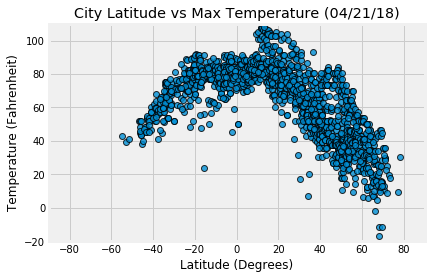

In [8]:
# Build a scatter plot for each data type
plt.scatter(city_data_df["city_lat"],
            city_data_df["city_max_temp"],
            edgecolor="black", linewidths=1, marker="o",
            alpha=0.8, label="City")

# Incorporate the other graph properties
chart_title = f'City Latitude vs Max Temperature ({record_date})'
plt.title(chart_title)
plt.ylabel("Temperature (Fahrenheit)")
plt.xlabel("Latitude (Degrees)")
plt.grid(True)
plt.xlim([-90, 90])
plt.ylim([-20, 110])
plt.savefig("output/lat_vs_max_temp.png")
plt.show()

## Latitude (Degrees) vs Humidity (%)

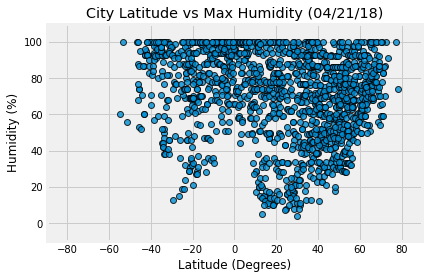

In [9]:
# Build a scatter plot for each data type
plt.scatter(city_data_df["city_lat"],
            city_data_df["city_humidity"],
            edgecolor="black", linewidths=1, marker="o",
            alpha=0.8, label="City")

# Incorporate the other graph properties
chart_title = f'City Latitude vs Max Humidity ({record_date})'
plt.title(chart_title)
plt.ylabel("Humidity (%)")
plt.xlabel("Latitude (Degrees)")
plt.grid(True)
plt.xlim([-90, 90])
plt.ylim([-10, 110])
plt.savefig("output/lat_vs_max_humidity.png")
plt.show()

## Latitude (Degrees) vs Cloudiness (%)

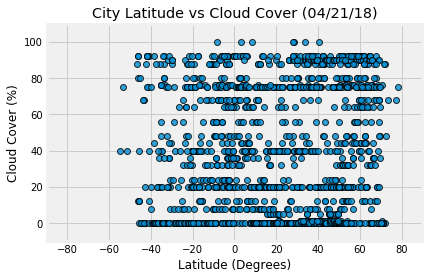

In [10]:
# Build a scatter plot for each data type
plt.scatter(city_data_df["city_lat"],
            city_data_df["city_cloud_cover"],
            edgecolor="black", linewidths=1, marker="o",
            alpha=0.8, label="City")

# Incorporate the other graph properties
chart_title = f'City Latitude vs Cloud Cover ({record_date})'
plt.title(chart_title)
plt.ylabel("Cloud Cover (%)")
plt.xlabel("Latitude (Degrees)")
plt.grid(True)
plt.xlim([-90, 90])
plt.ylim([-10, 110])
plt.savefig("output/lat_vs_cloud_cover.png")
plt.show()

## Latitude (Degrees) vs Windspeed (MPH)

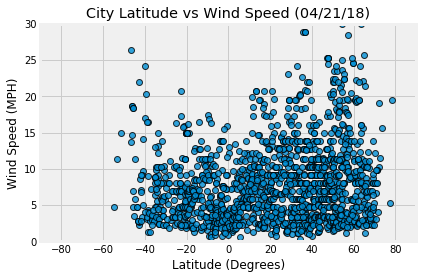

In [11]:
# Build a scatter plot for each data type
plt.scatter(city_data_df["city_lat"],
            city_data_df["city_wind_speed"],
            edgecolor="black", linewidths=1, marker="o",
            alpha=0.8, label="City")

# Incorporate the other graph properties
chart_title = f'City Latitude vs Wind Speed ({record_date})'
plt.title(chart_title)
plt.ylabel("Wind Speed (MPH)")
plt.xlabel("Latitude (Degrees)")
plt.grid(True)
plt.xlim([-90, 90])
plt.ylim([0, 30])
plt.savefig("output/lat_vs_wind_speed.png")
plt.show()